### Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
import copy

In [2]:
from skimage.filters import threshold_local

In [3]:
%matplotlib inline

In [4]:
from funcs import matplotlib_imshow

## **Thresholding ([Docs](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html))**

In computer vision, Thresholding refers to a technique used to **separate objects or regions of interest (ROI) from the background in an image or video based on pixel intensity values.** It involves selecting a threshold, each pixel is classified as either foreground or background based on whether its intensity value is above or below the threshold.

Thresholding is often used in image data pre-processing pipeline for tasks such as, Object detection, Image segmentation, Feature extraction, Noise reduction etc. 

- ### Global Thresholding

In the most basic case, for every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. To do this type of thresholding, OpenCV provides the `cv.threshold()` function.

> `cv.threshold(src_gray, threshold_val, max_val, thresholding_type)` function 

<u>Function Parameters</u>
- src: input image. Should be grayscale.
- threshold_val: thresholding value which is used for classifying the pixel values.
- max_val: value to be assigned to pixel values that exceeds threshold value.
- thresholding_type: thresholding technique. OpenCV offers 5 different basic thresholding types. 
    - cv.THRESH_BINARY
    - cv.THRESH_BINARY_INV
    - cv.THRESH_TRUNC
    - cv.THRESH_TOZERO
    - cv.THRESH_TOZERO_INV

**Returns:** The method returns two outputs. The first is the threshold value that was used and the second output is the thresholded image.

An example output of applying such thresholding types is shown below (picture taken from opencv docs; threshold value was 127 and max value was 255):

<img src="./imgs/basic_thresholding_applied.png">

To learn more about these thresholding types refer to the opencv documentation.

- ### Otsu's Binarization

In global thresholding, we used an arbitrary chosen value as a threshold. In contrast, Otsu's method avoids having to choose a value and determines it automatically.

Consider an image with only two distinct image values (bimodal image), where the histogram would only consist of two peaks. A good threshold would be in the middle of those two values. Similarly, Otsu's method determines an optimal global threshold value from the image histogram.

To apply `Otsu's binarization`, the `cv.threshold()` function is used, where `cv.THRESH_OTSU` is `passed as an extra flag`. The threshold value can be chosen arbitrarily (i.e, it has no effect). The algorithm then finds the **optimal threshold value** which is **returned as the first output.**

##### *Example of Global Thresholding and Otsu's Binarization*

In [5]:
# load the source image
scan_img = cv.imread(
    "./imgs/scan.jpeg", cv.IMREAD_GRAYSCALE
)  # or, cv.imread("./imgs/scan.jpeg", 0)

In [6]:
# Usually before thresholding, blurring is done. Blurring helps to reduce noise in the image.
scan_img_blurred = cv.GaussianBlur(scan_img, (5, 5), sigmaX=0.2, sigmaY=0.2)

In [7]:
# applying cv.THRESH_BINARY
thr_val, scan_img_thresh_binary = cv.threshold(
    scan_img_blurred, 127, 255, cv.THRESH_BINARY
)

In [8]:
# applying otsu binarization
opt_thresh, scan_img_otsu_binarized = cv.threshold(
    scan_img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
)

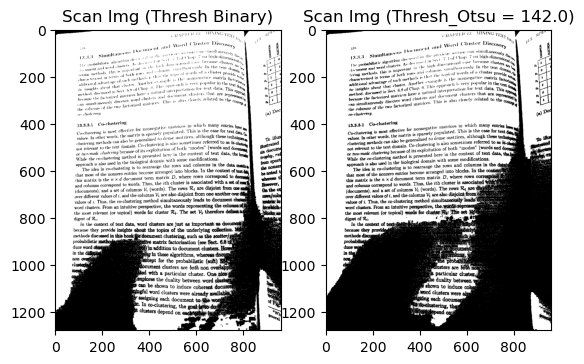

In [9]:
# Comparing the binary thresholded and otsu binarized image side by side
plt.subplot(1, 2, 1), plt.imshow(scan_img_thresh_binary, "gray"), plt.title(
    "Scan Img (Thresh Binary)"
)
plt.subplot(1, 2, 2), plt.imshow(scan_img_otsu_binarized, "gray"), plt.title(
    f"Scan Img (Thresh_Otsu = {opt_thresh})"
)
plt.show()

- ### Adaptive thresholding

In basic thresholding, we used one global value as a threshold. But this might not be good in all cases, e.g. for an image that has different lighting conditions in different areas. In that case, adaptive thresholding can help. Here, the algorithm determines the threshold for a pixel based on a small region around it. So we get different thresholds for different regions of the same image which gives better results for images with varying illumination.

> `cv.adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)` function

<u>Function Parameters</u>

- src: Source 8-bit single-channel (grayscale) image.
- maxValue:	Non-zero value assigned to the pixels that exceeds the threshold value.
- adaptiveMethod: Adaptive thresholding algorithm to use. Either `cv.ADAPTIVE_THRESH_MEAN_C` or `cv.ADAPTIVE_THRESH_GAUSSIAN_C`.
- thresholdType: Thresholding type that must be either `cv.THRESH_BINARY` or `cv.THRESH_BINARY_INV`.
- blockSize: Size of a pixel neighborhood that is used to calculate a threshold value for the pixel. **Should be odd** (3, 5, 7 and so on).
- C: Constant subtracted from the mean or weighted mean. Normally, it is positive but may be zero or negative as well.

In [10]:
# Adaptive Thresholding using cv.ADAPTIVE_THRESH_GAUSSIAN_C
scan_img_thresholded = cv.adaptiveThreshold(
    scan_img_blurred, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
)

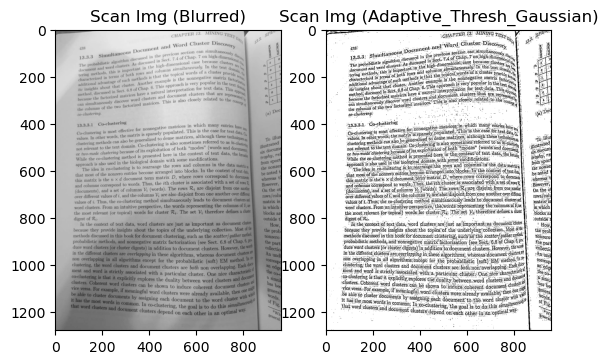

In [11]:
# Comparing the blurred image and gaussian adaptive thresholded image side by side
plt.subplot(1, 2, 1), plt.imshow(scan_img_blurred, "gray"), plt.title(
    "Scan Img (Blurred)"
)
plt.subplot(1, 2, 2), plt.imshow(scan_img_thresholded, "gray"), plt.title(
    "Scan Img (Adaptive_Thresh_Gaussian)"
)
plt.show()

- ### Sk-Image library for Adaptive thresholding ([Docs](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_local))

> The `skimage.filters.threshold_local(image, block_size=3, method='gaussian', offset=0)` function

<u>Function Parameters</u>
- image: input image (ndarray).
- block_size: Odd size of pixel neighborhood which is used to calculate the threshold value (e.g. 3, 5, …).
- method: Method used to determine adaptive threshold for local neighborhood in weighted mean image.
    - generic: use custom function (see param parameter)
    - gaussian: apply gaussian filter
    - mean: apply arithmetic mean filter
    - median: apply median rank filter
- offset: Constant subtracted from weighted mean of neighborhood to calculate the local threshold value. Default offset is 0.

**Returns:** Threshold image (ndarray). This array contains the threshold value calculated by the 'threshold_local()' function for each of the pixel in the input image.

**All elements (pixels) of the input image with value higher than the corresponding value of pixels in the threshold image are considered foreground.**

<b><u>Note:</u></b>
Before passing the image to the 'threshold_local' function, the image needs to be transformed to the `HSV` colorspace. 

The HSV colorspace has 3 components. `Hue: 0 - 179, Saturation: 0 - 255, Value (Intensity): 0 - 255`.

<img src="./imgs/hsv_color_space.png" height=300 width=500)>

In [12]:
# reading in image
scan_img_color = cv.imread("./imgs/scan.jpeg")
# applying gaussian blur
scan_img_color_blur = cv.GaussianBlur(scan_img_color, (5, 5), 0.2, 0.1)

In [13]:
scan_img_hsv = cv.cvtColor(scan_img_color_blur, cv.COLOR_BGR2HSV)

**`->`** When we convert an Image to the HSV color space, the 'ndarray' it returns is of the shape (width, height, 3) i.e, it contains 3 separate color channels, one for each of H,S and V component. So, we need to split the 3 channel HSV image array into separate H, S, V channels and pass the V component as the argument of 'image'. 

In [14]:
# Hue, Saturation and Value (intensity) matrices
H, S, V = cv.split(scan_img_hsv)
# or, V = cv.cvtColor(scan_img_color, cv.COLOR_BGR2HSV)[:, :, 2]

In [15]:
# threshold matrix for the input image
T = threshold_local(V, block_size=21, method="gaussian", offset=5).astype(
    np.uint8
)  # ndarray containing information about foreground

In [16]:
# At points where V > T it is considered foreground thus should have the value 255
# At points where V < T is is considered background thus should have the value 0
scan_img_thresholded_local_V = ((V > T).astype(np.uint8)) * 255

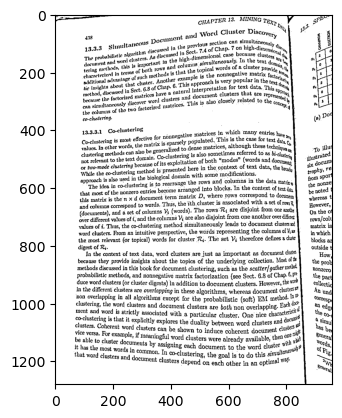

In [17]:
plt.imshow(scan_img_thresholded_local_V, "gray")

**`->`** To merge back the color channels we can use the, `cv.merge(ary_of_color_channels)` function.

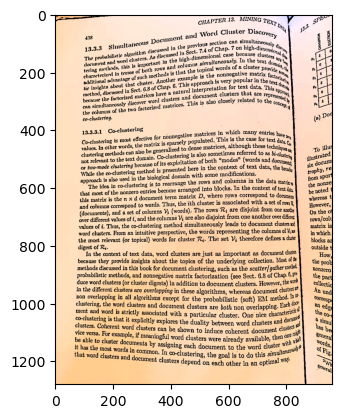

In [18]:
plt.imshow(
    cv.cvtColor(cv.merge([H, S, scan_img_thresholded_local_V]), cv.COLOR_HSV2RGB)
)